IMPORTING LIBRARIES

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from math import log10,sqrt,log2,ceil
import scipy.stats
from random import randint

FUNCTION FOR TRUCK MODEL

In [ ]:
def truck_model(states, truck_flag, truck_sensors):
  # Parameters
  m = 1000  # Mass [kg]
  g = 9.81  # Gravity [m/s^2]
  Cd = 0.78  # Drag coefficient [-]
  A = 10  # Frontal area [m^2]
  rho = 1  # Air density [kg/m^2]
  # States
  V = states[1]
  # Drag resistance
  C = 0.5 * rho * Cd * A
  Dx = C * V**2
  # Rolling resistance
  Rx = 0
  # Gravity force
  theta = 0  # Road slope [rad]
  Gx = m * g * np.sin(theta)  # [N]
  if truck_flag == 1:
    # CC
    V_r = 25  # Reference speed [m/s]
    Kp = 500  # Controller gain
    Ft = Kp * (V_r - V) + Dx  # Longitudinal force [N]
  else:
    sensor_distance_preceding = truck_sensors["distance_preceding"]
    sensor_speed_preceding = truck_sensors["speed_preceding"]
    # ACC
    th = 0.3  # Time gap [s]
    desired_distance = 2.5 * V / 3.6
    # desired_distance = th * V + 1.5
    Kp = 500
    Kv = 500
    Ft = Kp * (sensor_distance_preceding - desired_distance) + Kv * (
      sensor_speed_preceding - V
    ) + Dx
  # Vehicle Dynamics
  dstates = np.zeros_like(states)
  dstates[0], dstates[1] = V, (Ft - Dx - Rx - Gx) / m
  return dstates

FUNCTION FOR SIMULATION

In [ ]:
def simulation(z, t, parameters):
  truck_1_length = parameters["truck_1_length"]
  truck_2_length = parameters["truck_2_length"]
  truck_3_length = parameters["truck_3_length"]
  truck_4_length = parameters["truck_4_length"]
  # Truck 1
  truck_1_position, truck_1_speed = z[0], z[1]
  truck_1_states = [truck_1_position, truck_1_speed]
  # Truck 2
  truck_2_position, truck_2_speed = z[2], z[3]
  truck_2_states = [truck_2_position, truck_2_speed]
  # Truck 3
  truck_3_position, truck_3_speed = z[4], z[5]
  truck_3_states = [truck_3_position, truck_3_speed]
  # Truck 4
  truck_4_position, truck_4_speed = z[6], z[7]
  truck_4_states = [truck_4_position, truck_4_speed]
  # SENSORS
  # Truck 2
  Truck_2_sensors = {
    "distance_preceding": (truck_1_position - truck_1_length) - truck_2_position,
    "speed_preceding": truck_1_speed,
  }
  # Truck 3
  Truck_3_sensors = {
    "distance_preceding": (truck_2_position - truck_2_length) - truck_3_position,
    "speed_preceding": truck_2_speed,
  }
  # Truck 4
  Truck_4_sensors = {
    "distance_preceding": (truck_3_position - truck_3_length) - truck_4_position,
    "speed_preceding": truck_3_speed,
  }
  # DYNAMIC MODELS
  truck_1_derivative_states = truck_model(truck_1_states, 1, 1)
  truck_2_derivative_states = truck_model(truck_2_states, 2, Truck_2_sensors)
  truck_3_derivative_states = truck_model(truck_3_states, 3, Truck_3_sensors)
  truck_4_derivative_states = truck_model(truck_4_states, 4, Truck_4_sensors)
  # OUTPUT STATES
  dz = np.zeros_like(z)
  # Truck 1
  dz[0], dz[1] = truck_1_derivative_states[0], truck_1_derivative_states[1]
  # Truck 2
  dz[2], dz[3] = truck_2_derivative_states[0], truck_2_derivative_states[1]
  # Truck 3
  dz[4], dz[5] = truck_3_derivative_states[0], truck_3_derivative_states[1]
  # Truck 4
  dz[6], dz[7] = truck_4_derivative_states[0], truck_4_derivative_states[1]
  return dz

OTHER FUNCTIONS


In [ ]:
# def CQICUE(SNR) :
#     if SNR < -6.5 :
#         RB_all = 0
#         return RB_all
#     elif SNR < -4 :
#         RB_all = 16
#         return RB_all
#     elif SNR < -2.6 :
#         RB_all = 11
#         return RB_all
#     elif SNR < -1 :
#         RB_all = 7
#         return RB_all
#     elif SNR < 1 :
#         RB_all = 4
#         return RB_all
#     elif SNR < 6.6 :
#         RB_all = 3
#         return RB_all
#     elif SNR < 14.4 :
#         RB_all = 2
#         return RB_all
#     else :
#         RB_all = 1
#         return RB_all

# def CQIVUE(SNR) :
#     if SNR < 1.5 :
#         RB_all = 0
#         return RB_all
#     elif SNR < 4 :
#         RB_all = 4
#         return RB_all
#     elif SNR < 5.4 :
#         RB_all = 3
#         return RB_all
#     elif SNR < 7 :
#         RB_all = 2
#         return RB_all
#     else :
#         RB_all = 1
#         return RB_all

# def pathloss(linkType,f_c,d) :
#   bsAntGain = 8             # BS antenna gain 8 dBi
#   bsNoiseFigure = 7         # BS noise figure 7 dB
#   d2dAntGain = 5            # vehicle antenna gain 5 dBi
#   d2dNoiseFigure = 13       # vehicle noise figure 13 dB
#   if ((linkType).upper== 'V2V') :
#     if d<18:
#        pathloss= 38.77 + 20 * log10(d) + 20 * log10(f_c)       # LOS pathloss
#        PL_dB = -(np.random.randn()*3 + pathloss) + 2*d2dAntGain - d2dNoiseFigure
#     else :
#        pathloss = 36.85 + 30 * log10(d) + 18.9 * log10(f_c)    # NLOS pathloss
#        PL_dB = -(np.random.randn()*4 + pathloss) + 2*d2dAntGain - d2dNoiseFigure
#   else :
#       pathloss =  32.4 + 20 * log10(f_c) + 27 * log10(d)
#       PL_dB = -(np.random.randn()*6 + pathloss) + d2dAntGain + bsAntGain - bsNoiseFigure
#   return PL_dB

# def genDUE(numDUE):
#   d2dPos = []          # initilizer for vehicle position
#   indDUE = []
#   indDUE2 = []
#   pproc2 = []
#   numLane = 1
#   laneWidth = 4
#   v = 25                   # velocity
#   d_avg = 2.5*v/3.6         # average inter-vehicle distance according to TR 36.885
#   radius = 500
#   disBstoHwy = 25           # in meters
#   d0 = sqrt(radius**2-disBstoHwy**2)
#   ###### generate all d2d positions and store in d2dPos
#   for ilane in range(numLane) :
#     npoints = 4
#     pproc = [-500,-450,-410,-380]                                      # horizontal coordinates
#     for i in range(len(pproc)) :
#       z=np.zeros((1,2))
#       z[0,0] = pproc[i]
#       z[0,1] = disBstoHwy+ilane*laneWidth
#       pproc2.append(z)
#   d2dPos = pproc2
#   numd2d = len(d2dPos)
#   indPerm = np.random.permutation(numd2d)
#   indDUE = indPerm[0:numDUE]
#   indDUE2 = np.zeros(numDUE)
#   for ii in range(numDUE)  :
#     ######### pair each element in indDUE with closet vehicle and store the index in indDUE2  ##############
#     minDist = 2*d0
#     tmpInd = 0
#     for iii in range(numd2d) :
#         newDist = sqrt((d2dPos[indDUE[ii]][0][0]-d2dPos[iii][0][0])**2 + (d2dPos[indDUE[ii]][0][1]-d2dPos[iii][0][1])**2)
#         if newDist == 0:
#           continue
#         if newDist < minDist :
#           tmpInd = iii
#           minDist = newDist
#     indDUE2[ii] = tmpInd                              # the closest DUE pair
#   return d2dPos,indDUE,indDUE2

# def genCUE(xMin,xMax,yMin,yMax,numCUE) :
#   xDelta=xMax-xMin
#   yDelta=yMax-yMin
#   areaTotal=xDelta*yDelta
#   lambda0=100
#   numbPoints =scipy.stats.poisson( lambda0*areaTotal ).rvs() #Poisson number of points
#   xx = xDelta*scipy.stats.uniform.rvs(0,1,((numbPoints,1)))+xMin #x coordinates of Poisson points
#   yy = yDelta*scipy.stats.uniform.rvs(0,1,((numbPoints,1)))+yMin #y coordinates of Poisson points
#   x = []
#   y= []
#   for i in range(numCUE) :
#     x.append(xx[i])
#     y.append(yy[i])
#   return x,y

In [ ]:
# fc = 28                     # in GHz
# dB_noise = -114;           # noise power in dBm
# dB_Pd_max = 23            # d2d maximum power
# dB_Pc_max = 23              # CUE maximum power
# noise = 10**(dB_noise/10)
# Pd_max = 10**(dB_Pd_max/10)
# Pc_max = 10**(dB_Pc_max/10)
# numCUE = 100 #100
# z = int(numCUE/2)
# numV2V = 4
# coordCUE = np.zeros((numCUE,2))
# numRB = 32
# BW = 20    # in MHz

# x,y = genCUE(-500,25,-500,500,z)
# x1,y1 = genCUE(41,500,-500,500,z)
# for i in range(numCUE) :
#   if i < (numCUE/2)-1 :
#     coordCUE[i][0] = x[i]
#     coordCUE[i][1] = y[i]
#   else :
#     coordCUE[i][0] = x1[i-z-1]
#     coordCUE[i][1] = y1[i-z-1]

# size_V2V = 8*200 # in bits
# size_CUE = 8*500 # in bits

# d2dPos,indDUE,indDUE2 = genDUE(numV2V)
# indDUE = [int(i) for i in indDUE]
# indDUE2 = [int(i) for i in indDUE2]
# packetlossV2V = 0
# packetCUE = 0
# packetlossCUE = 0
# queueV2V = []
# queueCUE = []
# for i in range(5000) :
#   length = 0
#   throughputCUE=0
#   throughputV2V =0
#   pop_value = 0

#   if queueV2V != [] :
#     while length < len(queueV2V) :
#       if queueV2V[length][0] == 0 :
#         queueV2V.pop(length)
#         packetlossV2V += 1
#         length-=1
#       else :
#         queueV2V[length][0]-=1
#       length+=1

#   if queueCUE != [] :
#     while length < len(queueCUE) :
#       if queueCUE[length][0] == 0 :
#         queueCUE.pop(length)
#         packetlossCUE += 1
#         length-=1
#       else :
#         queueCUE[length][0]-=1
#       length+=1

#   if i%10 == 0 :
#     for V2Vuser in range(numV2V) :
#       if len(queueV2V) < 500 :
#         dist = sqrt((d2dPos[indDUE[V2Vuser]][0][0] - d2dPos[indDUE2[V2Vuser]][0][0])**2 + (d2dPos[indDUE[V2Vuser]][0][1] - d2dPos[indDUE2[V2Vuser]][0][1])**2)
#         PL = pathloss('V2V',fc,dist)
#         PL = 10**(PL/10)
#         x = [size_V2V,PL,'V2V']
#         queueV2V.append(x)
#       else :
#         packetlossV2V += 1

#   if i%20== 0 :
#     CUE_genpacket = []
#   numCUE_genpacket = np.random.poisson(numCUE/20)
#   packetCUE += numCUE_genpacket
#   j=0
#   while j <  numCUE_genpacket :
#     CUE = randint(0,numCUE-1)
#     if CUE in  CUE_genpacket :
#       if  len(CUE_genpacket) < (numCUE) :
#         continue
#       else :
#         break
#     else :
#       if len(queueCUE) < 500 :
#         dist = sqrt(coordCUE[CUE][0]**2 + coordCUE[CUE][1]**2)
#         PL = pathloss('CUE',fc,dist)
#         PL = 10**(PL/10)
#         x = [size_CUE,PL,'CUE']
#         queueCUE.append(x)
#         CUE_genpacket.append(CUE)
#         j+=1
#       else :
#         packetlossCUE += 1
#         j+=1

#   RB_available = 60
#   RB_TTI =0
#   queueV2V.sort()
#   queueCUE.sort()
#   for RB in range(8) :
#     if queueV2V != [] :
#       if pop_value < len(queueV2V) :
#         if RB_available > 0:
#           fading = np.zeros(RB_available)
#           fading =  0.5 * np.random.randn(RB_available) ** 2 + 0.5 * np.random.randn(RB_available) ** 2
#           fading.sort()
#           N =1
#           PL = queueV2V[0][1]
#           for k in range(4) :
#             SNR = (Pd_max) * (fading[N*-1]*PL)/ noise
#             SNR = 10*log10(SNR)
#             a = CQIVUE(SNR)
#             if a == N :
#               break
#             N+=1
#           if N <= 4 :
#             RB_TTI+=N
#             RB_available -= N
#             delayV2V = size_V2V - queueV2V[0][0]
#             throughputV2V+=size_V2V
#             queueV2V.pop(pop_value)
#           else :
#             pop_value +=1
#         else :
#           break
#     else :
#       break

#     if queueCUE != [] :
#       if pop_value < len(queueCUE) :
#         if RB_available > 0:
#           fading = np.zeros(RB_available)
#           fading =  0.5 * np.random.randn(RB_available) ** 2 + 0.5 * np.random.randn(RB_available) ** 2
#           fading.sort()
#           N =1
#           PL = queueCUE[0][1]
#           N=1
#           for k in range(16) :
#             SNR = (Pc_max) * (fading[N*-1]*PL)/ noise
#             SNR = 10*log10(SNR)
#             a = CQICUE(SNR)
#             if a == N :
#               break
#             N+=1
#           if N <= 16 :
#             RB_TTI+=N
#             RB_available -= N
#             delayCUE = size_CUE - queueCUE[0][0]
#             throughputCUE+=size_CUE
#             queueCUE.pop(pop_value)
#           else :
#             pop_value +=1
#         else :
#           break
#     else :
#       break
#   if i%20 == 0 :
#     packetlossCUEratio = packetlossCUE/packetCUE
#     packetCUE = 0
#     packetlossCUE = 0
#   if i%10 == 0 :
#     packetlossV2Vratio = packetlossV2V/10
#     packetV2V = 0
#     packetlossV2V = 0

MAIN PROGRAM

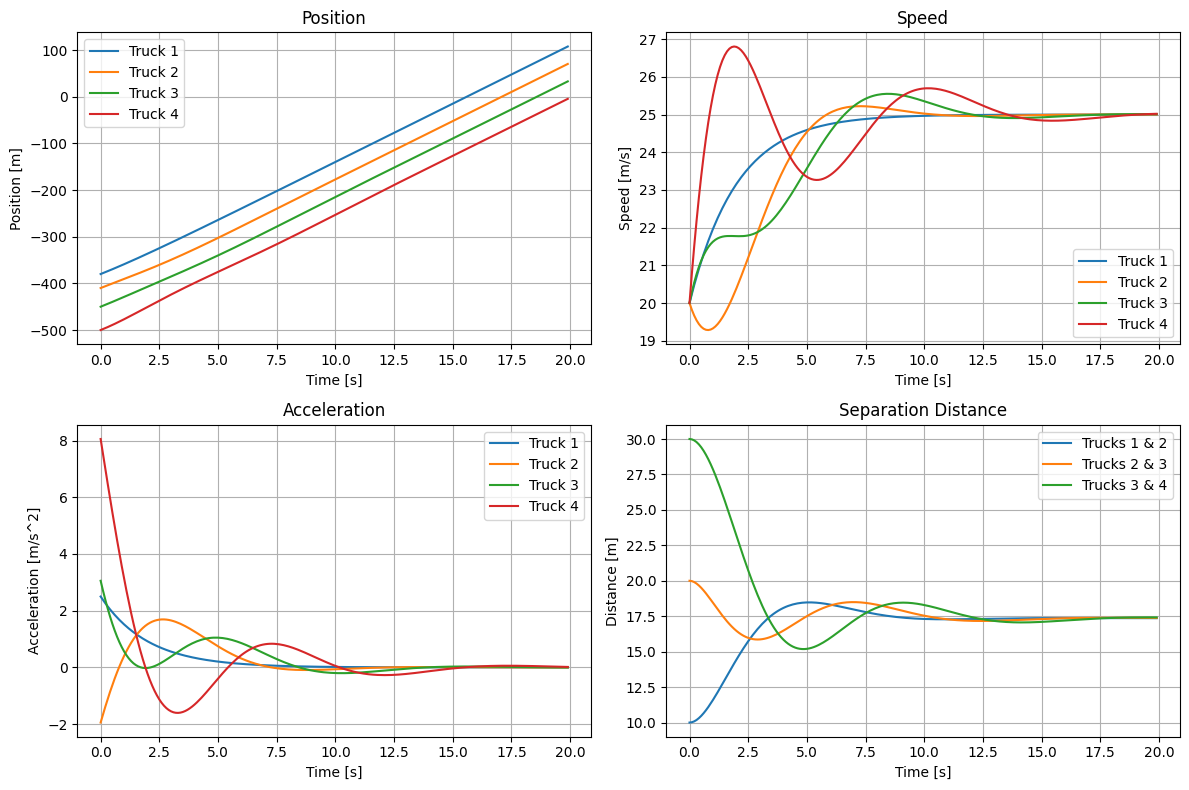

In [ ]:
# Parameters
fc      = 28                             # Carrier frequency [GHz]
BW      = 180                            # Bandwidth [kHz]
T       = 100                           # Control Time Interval [ms]
K       = 200                             # No. of control time intervals
timeCtr = np.arange(0, T*K/1000, T/1000) # Control Time [s]
# Truck 1 (Leading truck)
truck_1_length            = 20        # Length of the leading truck [m]
truck_1_initial_speed     = 72 / 3.6  # Speed of the leading truck [m/s]
truck_1_initial_position  = -380      # Initial position of the leading truck [m]
# Truck 2 (Second truck)
truck_2_length            = 20        # Length of the second truck [m]
truck_2_initial_speed     = 72 / 3.6  # Speed of the second truck [m/s]
truck_2_initial_position  = -410      # Initial position of the second truck [m]
# Truck 3 (Third truck)
truck_3_length            = 20        # Length of the third truck [m]
truck_3_initial_speed     = 72 / 3.6  # Speed of the third truck [m/s]
truck_3_initial_position  = -450      # Initial position of the third truck [m]
# Truck 4 (Fourth truck)
truck_4_length            = 20        # Length of the fourth truck [m]
truck_4_initial_speed     = 72 / 3.6  # Speed of the fourth truck [m/s]
truck_4_initial_position  = -500      # Initial position of the fourth truck [m]
# Initial Conditions
states_initial_condition = [
  truck_1_initial_position,
  truck_1_initial_speed,
  truck_2_initial_position,
  truck_2_initial_speed,
  truck_3_initial_position,
  truck_3_initial_speed,
  truck_4_initial_position,
  truck_4_initial_speed,
]
# Parameters for odeint
parameters = {
  "truck_1_length": truck_1_length,
  "truck_2_length": truck_2_length,
  "truck_3_length": truck_3_length,
  "truck_4_length": truck_4_length,
}
# Simulation
options = {"atol": 1e-9, "rtol": 1e-9}
result = odeint(lambda z, t: simulation(z, t, parameters), states_initial_condition, timeCtr, **options)
# Retrieving States
#Truck 1
truck_1_position  = result[:, 0]
truck_1_speed     = result[:, 1]
#Truck 2
truck_2_position  = result[:, 2]
truck_2_speed     = result[:, 3]
#Truck 3
truck_3_position  = result[:, 4]
truck_3_speed     = result[:, 5]
#Truck 4
truck_4_position  = result[:, 6]
truck_4_speed     = result[:, 7]
# Acceleration
truck_1_acc = np.zeros_like(timeCtr)
truck_2_acc = np.zeros_like(timeCtr)
truck_3_acc = np.zeros_like(timeCtr)
truck_4_acc = np.zeros_like(timeCtr)
for i in range(len(timeCtr)):
  dz = simulation(result[i, :], timeCtr[i], parameters)
  truck_1_acc[i] = dz[1]
  truck_2_acc[i] = dz[3]
  truck_3_acc[i] = dz[5]
  truck_4_acc[i] = dz[7]
# Distances
dist_1_2 = truck_1_position - truck_2_position - truck_1_length
dist_2_3 = truck_2_position - truck_3_position - truck_2_length
dist_3_4 = truck_3_position - truck_4_position - truck_3_length
# Results
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.plot(timeCtr, truck_1_position, timeCtr, truck_2_position, timeCtr, truck_3_position, timeCtr, truck_4_position)
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Position')
plt.legend(["Truck 1", "Truck 2", "Truck 3", "Truck 4"], loc='best')
plt.subplot(222)
plt.plot(timeCtr, truck_1_speed, timeCtr, truck_2_speed, timeCtr, truck_3_speed, timeCtr, truck_4_speed)
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('Speed [m/s]')
plt.title('Speed')
plt.legend(["Truck 1", "Truck 2", "Truck 3", "Truck 4"], loc='best')
plt.subplot(223)
plt.plot(timeCtr, truck_1_acc, timeCtr, truck_2_acc, timeCtr, truck_3_acc, timeCtr, truck_4_acc)
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s^2]')
plt.title('Acceleration')
plt.legend(["Truck 1", "Truck 2", "Truck 3", "Truck 4"], loc='best')
plt.subplot(224)
plt.plot(timeCtr, dist_1_2, timeCtr, dist_2_3, timeCtr, dist_3_4)
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('Distance [m]')
plt.title('Separation Distance')
plt.legend(['Trucks 1 & 2', 'Trucks 2 & 3', 'Trucks 3 & 4'], loc='best')
plt.tight_layout()
plt.show()